tb - 7/8/2022 - This notebook's goal is to compare the quality of the NNs trained on (-4K) by Jerry and that of the NNs used in the climate-invariant manuscript

# Imports and Initialization

## Imports

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *
from cbrain.climate_invariant_utils import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np

# import cartopy
# import cartopy.feature as cfeature
# import cartopy.crs as ccrs

from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import matplotlib.ticker as mticker
import matplotlib.transforms as mtrans
import matplotlib.pylab as plb

import pickle as pkl

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

In [3]:
# Load coordinates (just pick any file from the climate model run)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

## Paths

In [4]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']

In [5]:
path_Tom = ['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5',
            '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5']

In [85]:
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%
path_train_RH = path_data + '2021_01_24_O3_small_shuffle.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_train_BMSE = path_data + '2021_06_16_BMSE_small_shuffle.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'
path_train_LHF_nsDELQ = path_data + '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'

In [86]:
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions

In [87]:
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

## Load models

In [9]:
MODEL = {}

for ipath,path in enumerate(path_Tom):
    print('path=',path)
    MODEL[path] = load_model(path,compile=False)

path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5


## Define generators

In [89]:
def train_gen_rescaling(input_rescaling,path_norm,path_train,scale_dict):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [90]:
train_gen_RH = train_gen_rescaling(['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                   path_norm_RH,path_train_RH,scale_dict_RH)
train_gen_BMSE = train_gen_rescaling(['QBP','BMSE','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                     path_norm_BMSE,path_train_BMSE,scale_dict)
train_gen_LHF_nsDELQ = train_gen_rescaling(['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ'],
                                           path_norm_LHF_nsDELQ,path_train_LHF_nsDELQ,scale_dict)

In [91]:
Qscaling_array = [None,'RH']
Tscaling_array = [None,None]
LHFscaling_array = [None,None]

In [92]:
inp_sub_Qarray = [None,train_gen_RH.input_transform.sub]
inp_div_Qarray = [None,train_gen_RH.input_transform.div]
inp_sub_Tarray = [None,None]
inp_div_Tarray = [None,None]
inp_sub_LHFarray = [None,None]
inp_div_LHFarray = [None,None]

In [93]:
test_m4K = {}
test_p4K = {}

In [94]:
DataGeneratorCI

cbrain.climate_invariant.DataGeneratorCI

In [95]:
for ipath,path in enumerate(path_Tom):
    test_m4K[path] = DataGeneratorCI(data_fn = path_array['cold'][2],
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_input_norm,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=8192,
                                      shuffle=True,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array[ipath],
                                      Tscaling=Tscaling_array[ipath],
                                      LHFscaling=LHFscaling_array[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray[ipath],
                                      inp_div_Qscaling=inp_div_Qarray[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray[ipath],
                                      inp_div_Tscaling=inp_div_Tarray[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')
    test_p4K[path] = DataGeneratorCI(data_fn = path_array['hot'][2],
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_input_norm,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=8192,
                                      shuffle=True,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array[ipath],
                                      Tscaling=Tscaling_array[ipath],
                                      LHFscaling=LHFscaling_array[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray[ipath],
                                      inp_div_Qscaling=inp_div_Qarray[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray[ipath],
                                      inp_div_Tscaling=inp_div_Tarray[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')

# Calculate offline MSE/R$^2$ for a small sample of each set

In [146]:
lat_ind = np.arange(0,64)
Nbatches = 35
b_random = np.random.choice(np.linspace(0,5700,5701),size=((Nbatches,)),replace=False).astype('int')

In [147]:
MSE = {}; MSE_gen = {}; INP = {}; VAR = {};

In [148]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    MSE[dataset] = {}; INP[dataset] = {}; VAR[dataset] = {}; 
    MSE_gen[dataset] = {}; VAR_gen[dataset] = {};
    
    if idataset==0: train_gen_array = test_m4K
    elif idataset==1: train_gen_array = test_p4K
    
    for ipath,path in enumerate(path_Tom):
        print('path=',path)
            
        model = MODEL[path]
        train_gen = train_gen_array[path]
            
        for ibatch,ib in enumerate(b_random):
            print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")

            inp = train_gen[ib][0]
            tru = train_gen[ib][1]
            prd = model.predict_on_batch(inp)

            inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
            prd_geo = np.reshape(prd,(64,128,prd.shape[1]))
            tru_geo = np.reshape(tru,(64,128,tru.shape[1]))

            mse = np.expand_dims(np.mean((tru_geo-prd_geo)**2,axis=2),axis=2)
            var = np.expand_dims(tru_geo,axis=2)
            mse_gen = np.expand_dims(np.mean((tru_geo-prd_geo)[lat_ind,:,:]**2,axis=(0,1)),axis=1)

            if ibatch==0:
                MSE[dataset][path] = mse; 
                VAR[dataset][path] = var; 
                INP[dataset][path] = inp_geo;
                MSE_gen[dataset][path] = mse_gen;
            else:
                MSE[dataset][path] = np.concatenate((MSE[dataset][path],mse),axis=2)
                VAR[dataset][path] = np.concatenate((VAR[dataset][path],var),axis=2)
                INP[dataset][path] = np.concatenate((INP[dataset][path],inp_geo),axis=3)
                MSE_gen[dataset][path] = np.concatenate((MSE_gen[dataset][path],mse_gen),axis=1)

idataset= 0  & dataset= AQ-4K
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5
idataset= 1  & dataset= AQ+4K
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5


# Plots

In [135]:
VAR[dataset][path].shape

(64, 128, 30, 120)

In [109]:
MSE_gen[dataset][path].shape

(120, 10)

In [121]:
Rescaling = ['q input','RH input']

## MSE vertical profiles

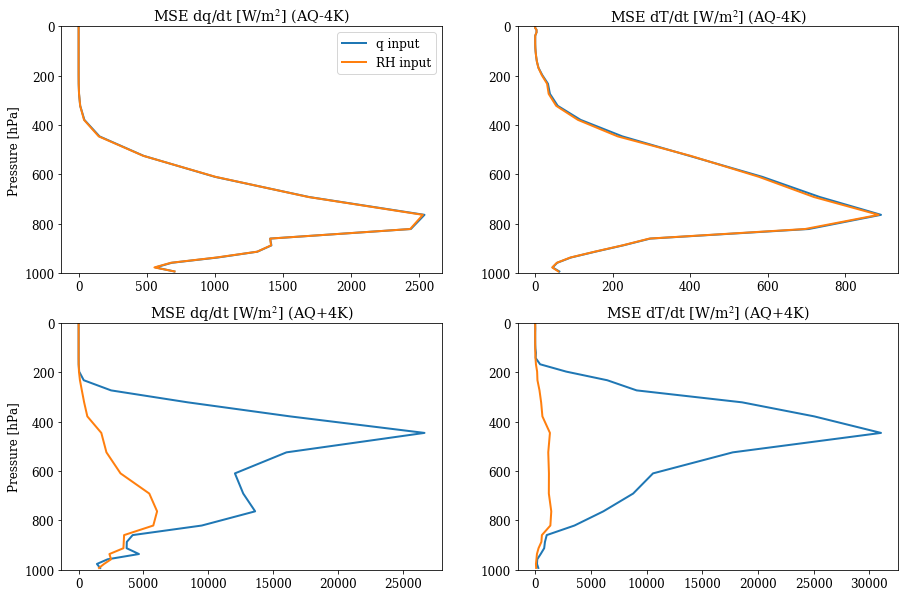

In [151]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

for row,dataset in enumerate(['AQ-4K','AQ+4K']):
    for ipath,path in enumerate(path_Tom):
        mse_q = np.mean(MSE_gen[dataset][path][:30,:],axis=1)
        ax[row][0].plot(mse_q,lev,label=Rescaling[ipath])
        ax[row][0].set_ylim((1000,0))
        ax[row][0].set_ylabel('Pressure [hPa]')
        ax[row][0].set_title('MSE dq/dt [W/m$^{2}$] ('+dataset+')')
        
        mse_T = np.mean(MSE_gen[dataset][path][30:60,:],axis=1)
        ax[row][1].plot(mse_T,lev)
        ax[row][1].set_ylim((1000,0))
        ax[row][1].set_title('MSE dT/dt [W/m$^{2}$] ('+dataset+')')
        
    if row==0: ax[row][0].legend()

## R$^{2}$

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


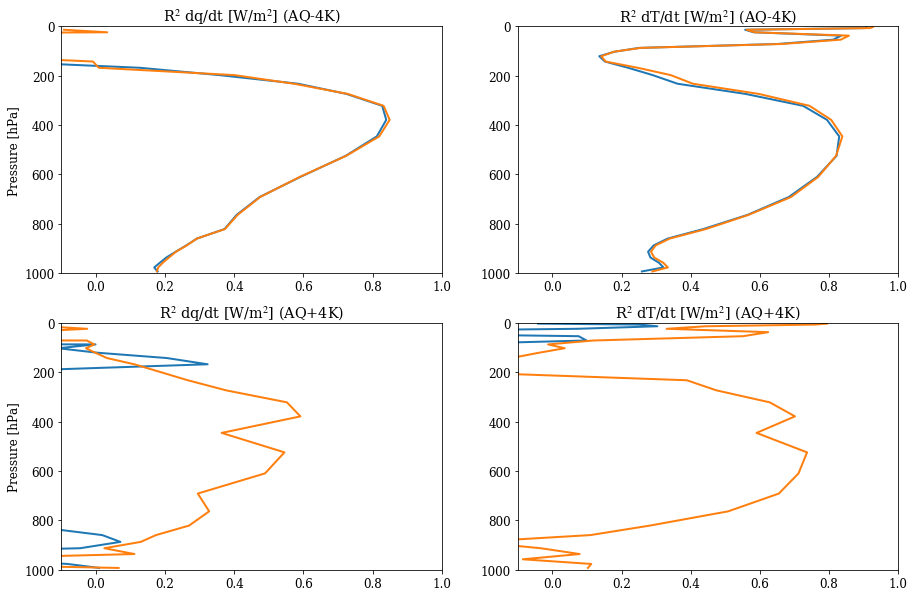

In [152]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

for row,dataset in enumerate(['AQ-4K','AQ+4K']):
    for ipath,path in enumerate(path_Tom):
        R2_q = 1-(np.mean(MSE_gen[dataset][path][:30,:],axis=1)/np.var(VAR[dataset][path][:,:,:,:30],axis=(0,1,2)))
        ax[row][0].plot(R2_q,lev)
        ax[row][0].set_ylim((1000,0))
        ax[row][0].set_xlim((-0.1,1))
        ax[row][0].set_ylabel('Pressure [hPa]')
        ax[row][0].set_title('R$^{2}$ dq/dt [W/m$^{2}$] ('+dataset+')')
        
        R2_T = 1-(np.mean(MSE_gen[dataset][path][30:60,:],axis=1)/np.var(VAR[dataset][path][:,:,:,30:60],axis=(0,1,2)))
        ax[row][1].plot(R2_T,lev)
        ax[row][1].set_ylim((1000,0))
        ax[row][1].set_xlim((-0.1,1))
        ax[row][1].set_title('R$^{2}$ dT/dt [W/m$^{2}$] ('+dataset+')')